### audio feature pulling stuff

In [8]:
import librosa

In [64]:
data, sampling = librosa.load('qantas.mp4')

In [66]:
sampling

22050

In [73]:
import os
import pandas as pd
import librosa
import glob
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

In [68]:
plt.figure(figsize=(12,4))

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

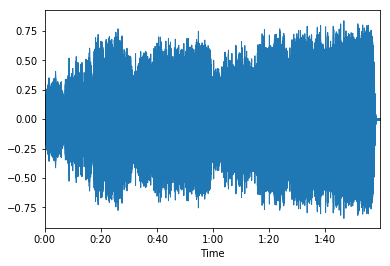

In [93]:
librosa.display.waveplot(data,sr=sampling)

In [28]:
sound = AudioSegment.from_file("H1H.mp4","mp4")
sound = sound.set_channels(1)
sound.export("H1H.wav", format="wav")

<_io.BufferedRandom name='H1H.wav'>

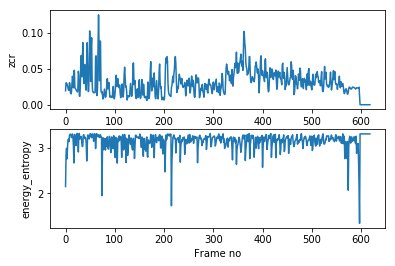

In [65]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
import matplotlib.pyplot as plt
from pydub import AudioSegment
[Fs, x] = audioBasicIO.readAudioFile("H1H.wav");
F, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.1*Fs, 0.05*Fs);
plt.subplot(2,1,1); plt.plot(F[0,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[0]); 
plt.subplot(2,1,2); plt.plot(F[2,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[2]); plt.show()

## new extract_tfrecords_main file to incorporate audio features

In [80]:
%%writefile extract_tfrecords_main.py
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS-IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Produces tfrecord files similar to the YouTube-8M dataset.

It processes a CSV file containing lines like "<video_file>,<labels>", where
<video_file> must be a path of a video, and <labels> must be an integer list
joined with semi-colon ";". It processes all videos and outputs tfrecord file
onto --output_tfrecords_file.

It assumes that you have OpenCV installed and properly linked with ffmpeg (i.e.
function `cv2.VideoCapture().open('/path/to/some/video')` should return True).

The binary only processes the video stream (images) and not the audio stream. *not any more!
"""

import csv
import os
import sys

import cv2
import feature_extractor
import numpy
import tensorflow as tf
from tensorflow import app
from tensorflow import flags
import os
import pandas as pd
import librosa
import glob
import librosa.display
import ffmpeg
import subprocess
import matplotlib as mpl
mpl.use('TkAgg')
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
from pydub import AudioSegment


FLAGS = flags.FLAGS

# In OpenCV3.X, this is available as cv2.CAP_PROP_POS_MSEC
# In OpenCV2.X, this is available as cv2.cv.CV_CAP_PROP_POS_MSEC
CAP_PROP_POS_MSEC = 0

if __name__ == '__main__':
    # Required flags for input and output.
    flags.DEFINE_string('output_tfrecords_file', None,
                      'File containing tfrecords will be written at this path.')
    flags.DEFINE_string('input_videos_csv', None,
                      'CSV file with lines "<video_file>,<labels>", where '
                      '<video_file> must be a path of a video and <labels> '
                      'must be an integer list joined with semi-colon ";"')
    # Optional flags.
    flags.DEFINE_string('model_dir', os.path.join(os.getenv('HOME'), 'yt8m'),
                      'Directory to store model files. It defaults to ~/yt8m')

    # The following flags are set to match the YouTube-8M dataset format.
    flags.DEFINE_integer('frames_per_second', 25,
                       'This many frames per second will be processed')
    flags.DEFINE_boolean('skip_frame_level_features', False,
                       'If set, frame-level features will not be written: only '
                       'video-level features will be written with feature '
                       'names mean_*')
    flags.DEFINE_string('labels_feature_key', 'labels',
                      'Labels will be written to context feature with this '
                      'key, as int64 list feature.')
    flags.DEFINE_string('image_feature_key', 'rgb',
                      'Image features will be written to sequence feature with '
                      'this key, as bytes list feature, with only one entry, '
                      'containing quantized feature string.')
    flags.DEFINE_string('video_file_feature_key', 'id',
                      'Input <video_file> will be written to context feature '
                      'with this key, as bytes list feature, with only one '
                      'entry, containing the file path of the video. This '
                      'can be used for debugging but not for training or eval.')
    flags.DEFINE_boolean('insert_zero_audio_features', False,
                       'If set, inserts features with name "audio" to be 128-D '
                       'zero vectors. This allows you to use YouTube-8M '
                       'pre-trained model.')


def frame_iterator(filename, every_ms=40, max_num_frames=3000):
    """Uses OpenCV to iterate over all frames of filename at a given frequency.

    Args:
        filename: Path to video file (e.g. mp4)
        every_ms: The duration (in milliseconds) to skip between frames.
        max_num_frames: Maximum number of frames to process, taken from the
        beginning of the video.

    Yields:
        RGB frame with shape (image height, image width, channels)
    """
    video_capture = cv2.VideoCapture()
    if not video_capture.open(filename):
        print('Error: Cannot open video file ' + filename,file=sys.stderr)
        return
    last_ts = -99999  # The timestamp of last retrieved frame.
    num_retrieved = 0

    while num_retrieved < max_num_frames:
    # Skip frames
        while video_capture.get(CAP_PROP_POS_MSEC) < every_ms + last_ts:
            if not video_capture.read()[0]:
                return

        last_ts = video_capture.get(CAP_PROP_POS_MSEC)
        has_frames, frame = video_capture.read()
        if not has_frames:
            break
        yield frame
        num_retrieved += 1


def _int64_list_feature(int64_list):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=int64_list))

def _float_list_feature(float_list):
    return tf.train.Feature(float_list=tf.train.FloatList(value=float_list))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _make_bytes(int_array):
    if bytes == str:  # Python2
        return ''.join(map(chr, int_array))
    else:
        return bytes(int_array)


def quantize(features, min_quantized_value=-2.0, max_quantized_value=2.0):
    """Quantizes float32 `features` into string."""
    assert features.dtype == 'float32'
    assert len(features.shape) == 1  # 1-D array
    features = numpy.clip(features, min_quantized_value, max_quantized_value)
    quantize_range = max_quantized_value - min_quantized_value
    features = (features - min_quantized_value) * (255.0 / quantize_range)
    features = [int(round(f)) for f in features]

    return _make_bytes(features)


def main(unused_argv):
    extractor = feature_extractor.YouTube8MFeatureExtractor(FLAGS.model_dir)
    writer = tf.python_io.TFRecordWriter(FLAGS.output_tfrecords_file)
    total_written = 0
    total_error = 0
    for video_file, labels in csv.reader(open(FLAGS.input_videos_csv)):
        rgb_features = []
        sum_rgb_features = None
        for rgb in frame_iterator(
            video_file, every_ms=1000/FLAGS.frames_per_second):
                features = extractor.extract_rgb_frame_features(rgb[:, :, ::-1])
                if sum_rgb_features is None:
                    sum_rgb_features = features
                else:
                    sum_rgb_features += features
                rgb_features.append(_float_list_feature(features))
            
        if not rgb_features:
            print('Could not get features for ' + video_file, file=sys.stderr)
            total_error += 1
            continue
    
        mean_rgb_features = sum_rgb_features / len(rgb_features)
        if not FLAGS.insert_zero_audio_features:
            aud_features = []
            sum_aud_features = None
            sound = AudioSegment.from_file(video_file,video_file[-3:])
            sound = sound.set_channels(1)
            sound.export(video_file[:-4]+'.wav', format="wav")
            aud_file = video_file[:-4]+'.wav'
            [Fs, x] = audioBasicIO.readAudioFile(aud_file);
            a_feats, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.08*Fs, 0.04*Fs);
            a_feats = [numpy.array([a_feats[i][j] for i in range(len(a_feats))]) for j in range(len(a_feats[0]))]
            sum_aud_features = sum(a_feats)
            mean_aud_features = sum_aud_features / len(a_feats)
            for i in range(len(a_feats)):
                aud_features.append(_float_list_feature(a_feats[i]))
        # Create SequenceExample proto and write to output.
        feature_list = {
            FLAGS.image_feature_key: tf.train.FeatureList(feature=rgb_features),
        }
        context_features = {
            FLAGS.labels_feature_key: _int64_list_feature(
                sorted(map(int, labels.split(';')))),
            FLAGS.video_file_feature_key: _bytes_feature(_make_bytes(
                map(ord, video_file))),
            'mean_' + FLAGS.image_feature_key: tf.train.Feature(
                float_list=tf.train.FloatList(value=mean_rgb_features)),
        }

        if FLAGS.insert_zero_audio_features:
            aud_vec = [0] * 128
            feature_list['audio'] = tf.train.FeatureList(
            feature=[_bytes_feature(_make_bytes(aud_vec))] * len(rgb_features))
            context_features['mean_audio'] = tf.train.Feature(
            float_list=tf.train.FloatList(value=aud_vec))
        else:
            aud_vec = aud_features
            feature_list['audio'] = tf.train.FeatureList(feature=aud_vec)
            context_features['mean_audio'] = tf.train.Feature(
            float_list=tf.train.FloatList(value=mean_aud_features))

        if FLAGS.skip_frame_level_features:
            example = tf.train.SequenceExample(
                context=tf.train.Features(feature=context_features))
        else:
            example = tf.train.SequenceExample(
                context=tf.train.Features(feature=context_features),
                feature_lists=tf.train.FeatureLists(feature_list=feature_list))
        writer.write(example.SerializeToString())
        total_written += 1
        print(str(total_written)+' vids done')

    writer.close()
    print('Successfully encoded %i out of %i videos' % (
        total_written, total_written + total_error))


if __name__ == '__main__':
    app.run(main)


Overwriting extract_tfrecords_main.py


### looking at tfrecords file

In [1]:
import numpy as np
import tensorflow as tf
sess = tf.Session()
context_features = {
    'id' : tf.FixedLenFeature([1], dtype=tf.string),
    'labels': tf.FixedLenFeature([1],dtype=tf.int64),
    'mean_rgb': tf.FixedLenFeature([1024], dtype=tf.float32),
    'mean_audio': tf.FixedLenFeature([34],dtype=tf.float32)
}

sequence_features = {
    'rgb': tf.FixedLenSequenceFeature([1024], dtype=tf.float32),
    'audio': tf.FixedLenSequenceFeature([34], dtype=tf.float32)
}

def parse(record):
    parsed = tf.parse_single_sequence_example(
        record,
        context_features=context_features,
        sequence_features=sequence_features
    )
    return parsed



dataset = tf.data.TFRecordDataset('118_w_aud.tfrecord').map(lambda r: parse(r))

iterator = tf.data.Iterator.from_structure(dataset.output_types,
                                           dataset.output_shapes)
next_element = iterator.get_next()

training_init_op = iterator.make_initializer(dataset)

sess.run(training_init_op)
ne = []
for _ in range(118):
    ne.append(sess.run(next_element))

In [78]:
ne[0]

({'id': array([b'A591_h1i_h1j_YT_FB_Cricket_Data_Bank.mov'], dtype=object),
  'labels': array([315]),
  'mean_audio': array([ 4.9357411e-02,  2.4587709e-02,  3.0837586e+00,  1.0857440e-01,
          1.4932270e-01,  2.8899333e-01,  3.4210542e-03,  7.7791251e-02,
         -2.5747019e+01,  1.6040721e+00, -7.5433797e-01,  2.9504710e-01,
          4.3509439e-02,  3.6070055e-01, -1.2741391e-01, -1.8293357e-01,
          2.2136252e-01, -7.7633679e-02, -7.1545191e-02, -5.7573784e-02,
         -5.0886467e-02,  2.1105168e-02,  6.2340298e-03,  1.7753752e-02,
          1.2117387e-02,  1.6961398e-02,  1.9329611e-02,  2.6223579e-02,
          1.8561116e-03,  7.7004246e-03,  9.8127285e-03,  2.6440749e-02,
          1.0465404e-02,  2.1833356e-02], dtype=float32),
  'mean_rgb': array([-0.610425  , -1.1026496 , -0.74791276, ..., -0.4629344 ,
         -0.49474975, -0.4780776 ], dtype=float32)},
 {'audio': array([[3.7507815e-03, 4.1676014e-08, 2.2590921e+00, ..., 4.7893734e-03,
          1.4620909e-04, 4.

In [3]:
ok = []
for k in range(2):
    ok.append([[ne[4*k][1]['rgb'][i][j] for j in range(1*len(ne[4*k][1]['rgb'][0]))] for i in range(1*len(ne[4*k][1]['rgb']))])
ok
    
             

[[[0.6259578,
   -0.36766362,
   -0.8326955,
   -1.7594991,
   0.09525137,
   0.6265584,
   -0.26571402,
   1.5365756,
   1.733136,
   -0.034150567,
   -1.093494,
   -1.3633047,
   0.06640192,
   0.48623574,
   -0.595359,
   1.6609205,
   0.26105362,
   2.7749126,
   0.8538496,
   1.6788934,
   0.39318892,
   -1.195131,
   1.0630678,
   1.287485,
   -0.7129748,
   -1.4710135,
   -1.4592856,
   0.29362446,
   0.8085695,
   1.3409821,
   0.2857762,
   -0.25752944,
   3.1653724,
   -1.3901097,
   0.8107845,
   0.9109122,
   -3.3704045,
   1.0564077,
   -0.83868474,
   1.1150905,
   -1.5671808,
   -1.5950594,
   -0.37489074,
   -0.030524105,
   1.0357394,
   1.4175569,
   1.3879906,
   -0.19025342,
   -0.49545142,
   0.5460184,
   0.64291465,
   -1.3154305,
   0.6502108,
   -1.2983786,
   -0.37325984,
   -3.0093775,
   1.9289407,
   -0.6161893,
   -1.4473336,
   -1.400945,
   0.1455632,
   0.15098238,
   -1.9374367,
   1.487937,
   1.5829157,
   1.1639618,
   -0.29850748,
   2.1079338,
   

In [5]:
np.array(ok,dtype=np.float64).shape

(2, 15, 1024)

## visualising individual embeddings in one video

In [73]:
import numpy as np

X = ne[0][1]['rgb']
y = np.linspace(1,15,15)

print(X.shape, y.shape)

(15, 1024) (15,)


In [74]:
import pandas as pd

feat_cols = ['rgb feat'+str(i) for i in range(X.shape[1])]

df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i+100))

X, y = None, None

print('Size of the dataframe: {}'.format(df.shape))


Size of the dataframe: (15, 1025)


In [75]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.3886803  0.27585778 0.17358401]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

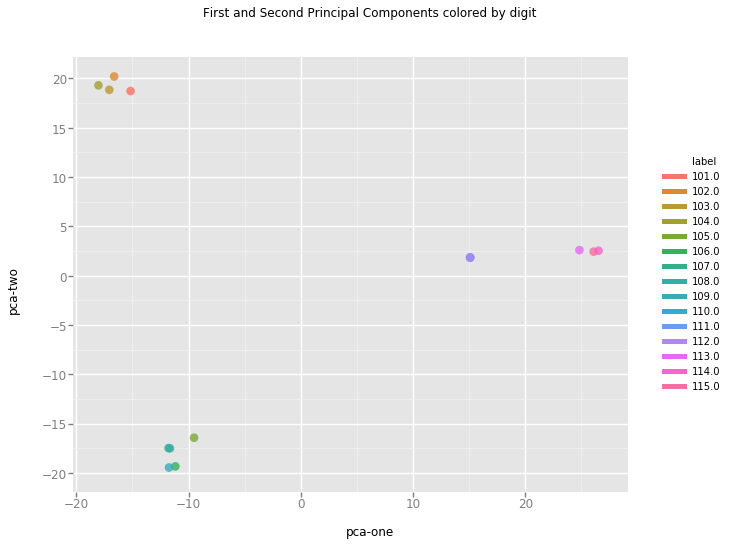

<ggplot: (-9223372029277093544)>

In [76]:
from ggplot import *
import pandas as pd

chart = ggplot(df.loc[:,:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart


In [59]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[:,feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 299 samples in 0.006s...
[t-SNE] Computed neighbors for 299 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 299 / 299
[t-SNE] Mean sigma: 0.877428
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.931850
[t-SNE] KL divergence after 300 iterations: 0.329444
t-SNE done! Time elapsed: 0.6376180648803711 seconds


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

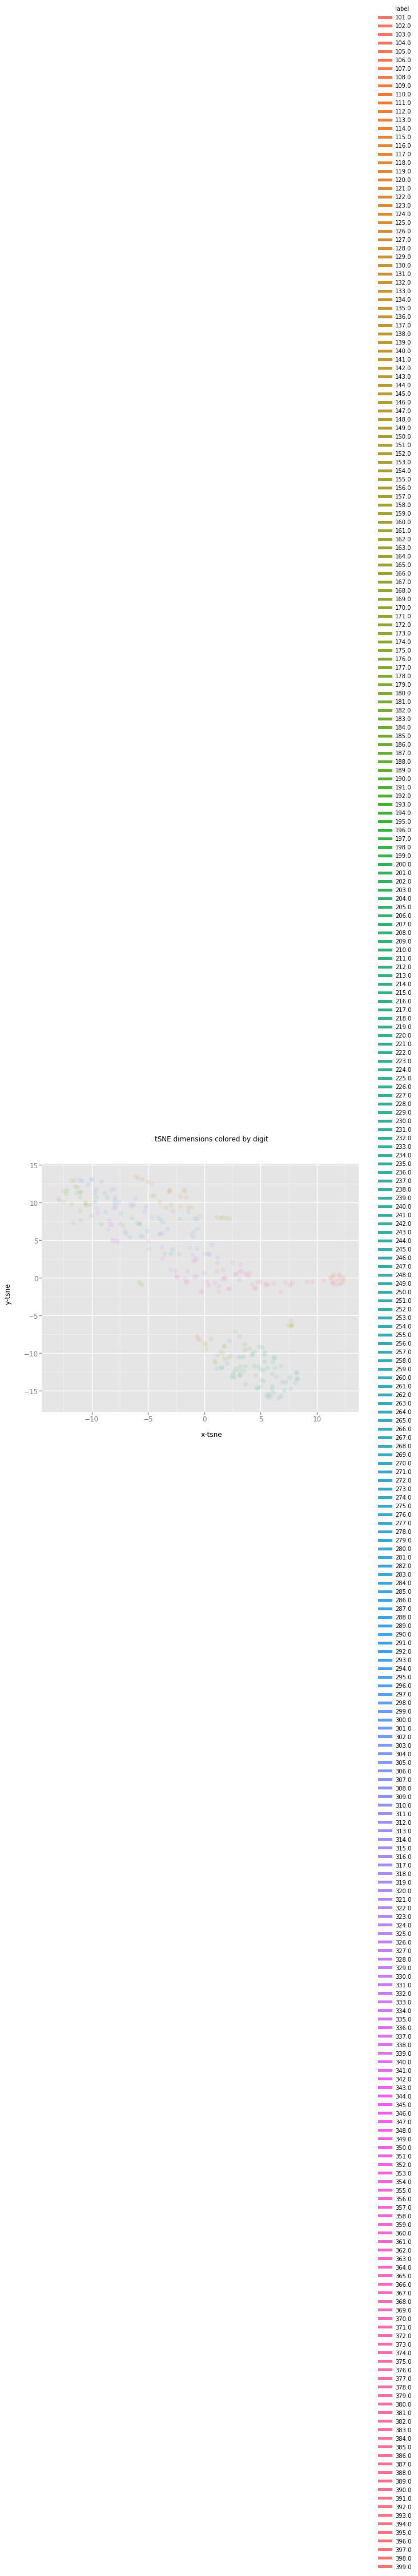

<ggplot: (7578518578)>

In [60]:
df_tsne = df.loc[:,:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

In [69]:
pca_50 = PCA(n_components=20)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9999359250068665


In [70]:
n_sne = 10000

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50[:])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 299 samples in 0.001s...
[t-SNE] Computed neighbors for 299 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 299 / 299
[t-SNE] Mean sigma: 0.877220
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.648613
[t-SNE] KL divergence after 300 iterations: 0.346032
t-SNE done! Time elapsed: 0.6302011013031006 seconds


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

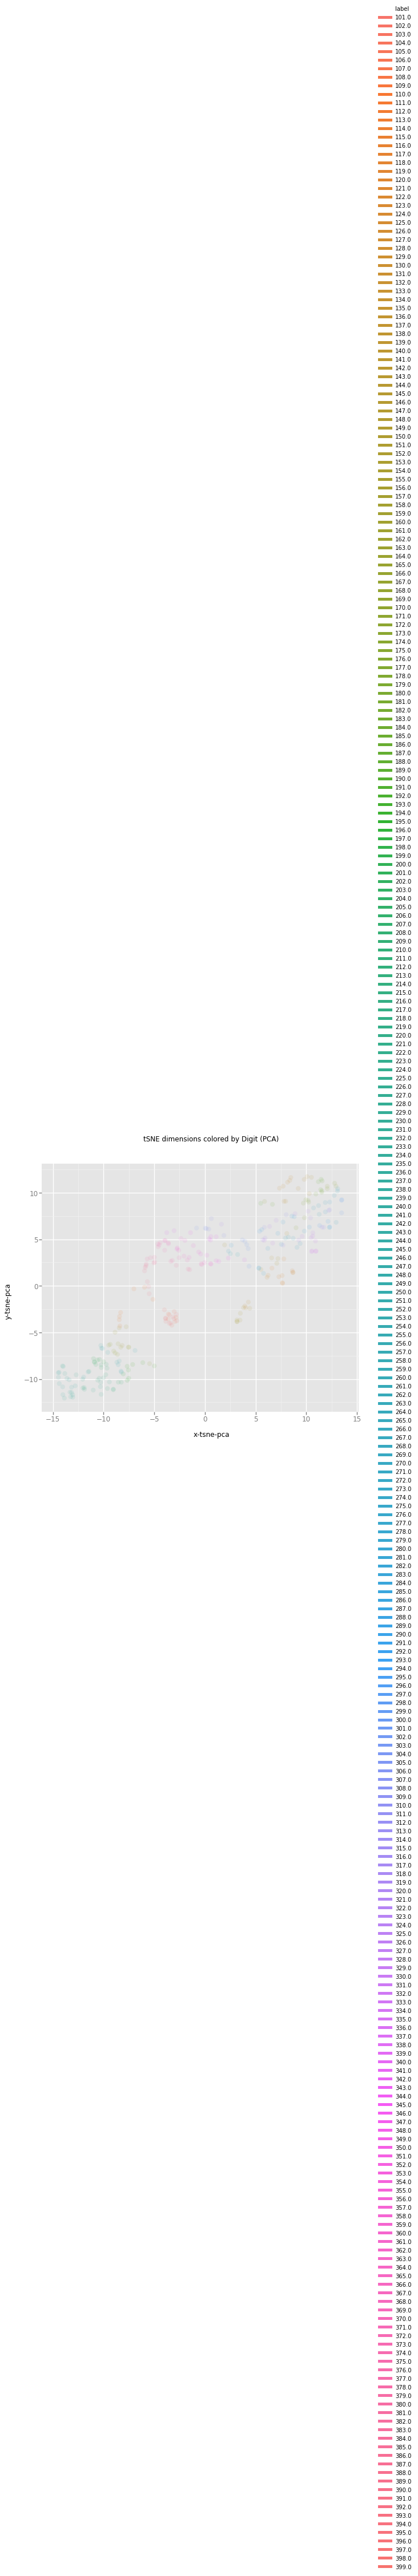

<ggplot: (-9223372029274871394)>

In [71]:
df_tsne = None
df_tsne = df.loc[:,:].copy()
df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne-pca', y='y-tsne-pca', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by Digit (PCA)")
chart

#### useful template for cleaning txt file

In [9]:
infile = r"cleaned_files.txt"
outfile = r"cleaned_files2.txt"

delete_list = [";"]
fin=open(infile,"r")
fout = open(outfile,"w+")
for line in fin:
    for word in delete_list:
        line = line.replace(word, ",")
    fout.write(line)
fin.close()
fout.close()